In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

# Probability and likelihood

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from rlxutils import subplots
import itertools
%matplotlib inline

We have data representing draws of a biased coin.

$$x = [x_0, x_1, x_2, x_3]$$

but we **don't know** the probability of the biased coin.

This is a Bernoulli distribution with **unknown** parameter $p$.

$$x \sim \text{Bernoulli}(p)$$

The probability assigned to $x$, depends on a choice of $p$

$$P(x|p) = \prod_i P(x_i|p)$$

## Probability

If we set $p$ **fixed** and consider different datasets we have a **discrete** probability distribution, that assigns a probability to each dataset. And, in this very simple setting,  we have 16 possible datasets.


In all practical settings having an exhaustive list of all datasets is simply impossible. Think, for instance, of all possible datasets of 1000 customers described by age, profession, income, credit history,.... This would mean **all** combinations of **all** possible values for each feature.

In [331]:
all_datasets = np.r_[list(itertools.product(*[[0,1]]*4))]
all_datasets

array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 1],
       [0, 1, 1, 0],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0],
       [1, 0, 1, 1],
       [1, 1, 0, 0],
       [1, 1, 0, 1],
       [1, 1, 1, 0],
       [1, 1, 1, 1]])

the conditional probability function

In [356]:
P_x_given_p = lambda x,p: np.prod(stats.bernoulli(p).pmf(x))

we fix p, so we have a function of x

In [337]:
fixed_p=.3
P_x_fixed_p = lambda x: P_x_given_p(x, fixed_p)

and we **DO** have a discrete probability distribution for this fixed p.

The expression $P(x|p)$ with a fixed $p$ and varying $x$ **is a discrete probability distribution**.

In [354]:
probs = np.r_[[P_x_fixed_p(dataset) for dataset in all_datasets]]
print ("all probabilities", probs)
print ("\ncheck sum of probabilities", np.sum(probs))

all probabilities [0.2401 0.1029 0.1029 0.0441 0.1029 0.0441 0.0441 0.0189 0.1029 0.0441
 0.0441 0.0189 0.0441 0.0189 0.0189 0.0081]

check sum of probabilities 0.9999999999999998


Text(0.5, 1.0, 'probability distribution P(x|p) with p fixed')

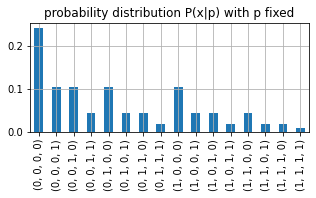

In [351]:
pd.Series(probs, index=[tuple(i) for i in all_datasets]).plot(figsize=(5,2), kind='bar')
plt.grid();plt.title("probability distribution P(x|p) with p fixed")

## Likelihood

If we set $x$ **fixed** and consider different values of $p$ we have a **likelihood** function. This **IS NOT** a probability function

We fix $x$, so we have a function of $p$

In [357]:
fixed_x = np.r_[1,0,1,1]
likelihood = lambda p: P_x_given_p(fixed_x, p)

this is a continuous function, and it is not a probability distribution since it does not integrate to 1.

$$\int_0^1 P(x_{fixed}|p) \text{d}p$$

in this case the integration is between 0 and 1 since, by definition, $p \in [0,1]$

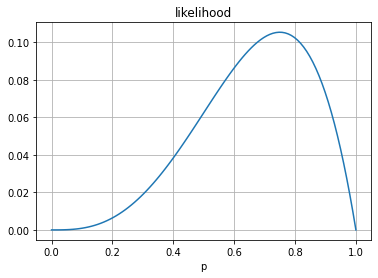

In [361]:
pr = np.linspace(.0,1., 100)
plt.plot(pr, [likelihood(pi) for pi in pr])
plt.title("likelihood"); plt.grid();
plt.xlabel("p");

In [365]:
# the integral
from scipy.integrate import quad
quad(likelihood, 0,1)[0]

0.05

## Maximum likelihood estimation

but we can ask, what is the value of $p$ that that assigns more probability to the data that we have seen?

$$l(p) =  \prod_i P(x_i|p) \;\;\;\;\text{with }x\text{ fixed}$$

In [424]:
from scipy.optimize import minimize

# negative function for maximization
# constrained to possible values
r = minimize(lambda p: -likelihood(p), np.random.random(),
             constraints = ({'type':'ineq', 'fun': lambda p: p},
                            {'type':'ineq', 'fun': lambda p: 1-p} )
            
            ) 
r

     fun: -0.10546865449586039
     jac: array([-0.00065521])
 message: 'Optimization terminated successfully'
    nfev: 13
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.74970856])

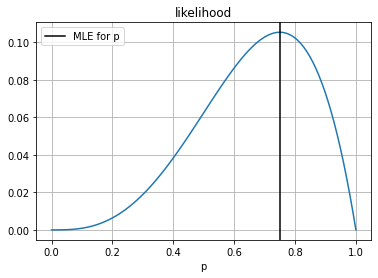

In [425]:
pr = np.linspace(.0,1., 100)
plt.plot(pr, [likelihood(pi) for pi in pr])
plt.title("likelihood"); plt.grid();
plt.xlabel("p");
plt.axvline(r.x[0], color="black", label="MLE for p")
plt.legend()

and one usually maximizes the $\log$ likelihood since it is monotonic, nicely turns multiplications into summations and has much less numerical issues.

To maximize the likelihood, we maximize the log likelihood.

$$\mathcal{L}(p) = \log l(p) =  \log \prod_i P(x_i|p) = \sum_i \log P(x_i|p)$$

In [407]:
# original conditional distribution function
P_x_given_p = lambda x,p: np.prod(stats.bernoulli(p).pmf(x))

# log likelihood function
log_likelihood = lambda p: np.sum(np.log(stats.bernoulli(p).pmf(fixed_x)+1e-7))

In [408]:
np.exp(log_likelihood(.2)), likelihood(.2)

(0.006400010400006, 0.006400000000000002)

In [422]:
r = minimize(lambda p: -log_likelihood(p), np.random.random(), 
             constraints = ({'type':'ineq', 'fun': lambda x: x},
                            {'type':'ineq', 'fun': lambda x: 1-x} )
            )
r


     fun: 2.2493397926615546
     jac: array([-0.00077778])
 message: 'Optimization terminated successfully'
    nfev: 13
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.74996358])

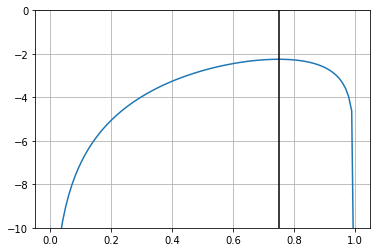

In [423]:
plt.plot(pr, [log_likelihood(pi) for pi in pr])
plt.ylim(-10,0); plt.grid();
plt.axvline(r.x[0], color="black", label="MLE for p")


## Likelihood on continuous distributions

let's consider the data from the UCI ML repository, [Abalone dataset](https://archive.ics.uci.edu/ml/datasets/Abalone)

we will focus only on the marginal distribution of the variable **length**, and we will scale it so that it has values between 0 and 1

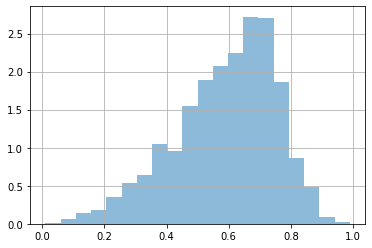

In [481]:
dataset = pd.read_csv("local/data/abalone.data.gz", 
                names=["sex", "length", "diameter", "height", "whole weight", "shucked weight",
                         "viscera weigth", "shell weight", "rings"])

from sklearn.preprocessing import MinMaxScaler

x = dataset['diameter'].values
x = MinMaxScaler(feature_range=(0.01,.99)).fit_transform(x.reshape(-1,1)).reshape(-1)
#x = x[np.random.permutation(len(x))[:1000]]
plt.hist(x, bins=20, density=True, alpha=.5);
plt.grid();


We are told that **MAYBE** we can model this data with a $\mathcal{B}$ (beta) distribution.

Seeing the shape of our histogram and the shapes produced by a [$\mathcal{B}$ distribution](https://en.wikipedia.org/wiki/Beta_distribution) this seems a reasonable assumption.

The beta distribution is governed by two parameters, $a$ and $b$.

We show now several $\mathcal{B}$, and the log likelihood is a function of two parameters

$$\mathcal{L}(a,b) = \log \prod P(x|a,b)$$

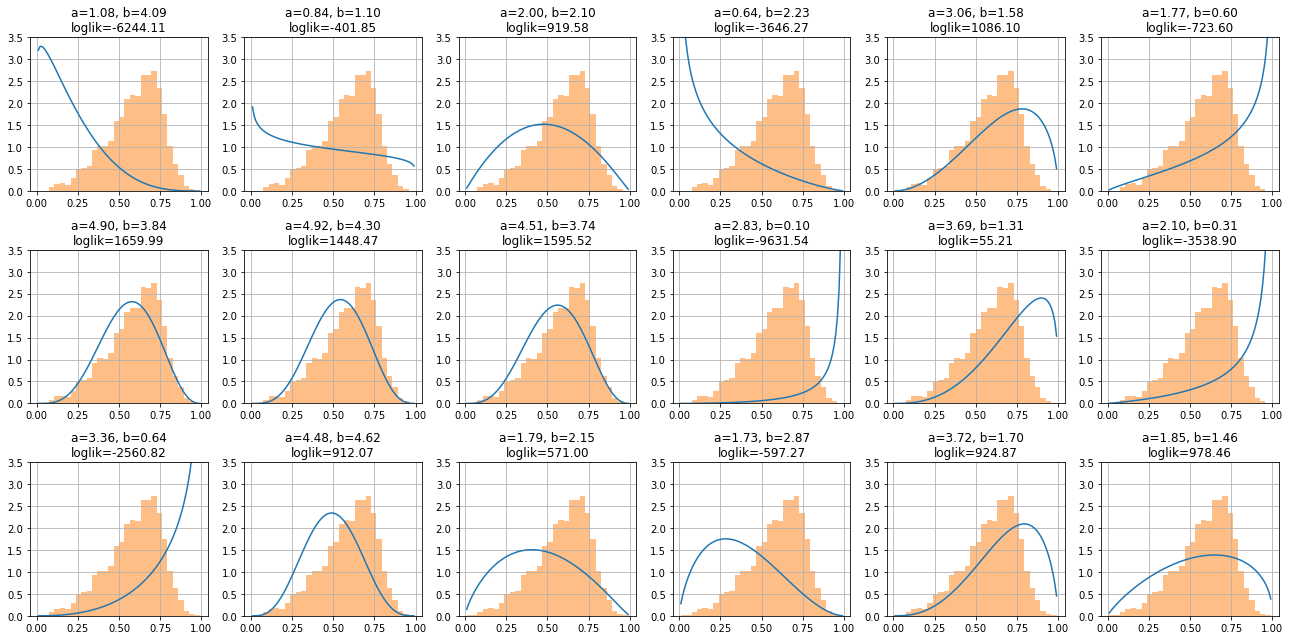

In [483]:
loglik = lambda a,b: np.sum(np.log(stats.beta(a,b).pdf(x)+1e-7))

xr = np.linspace(0.01,.99,100)
plist = list(itertools.product(ar,br))
for ax,_ in subplots(18, n_cols=6):
    a,b = (np.random.random(2)+.01)*5
    beta = stats.beta(a=a, b=b)
    plt.plot(xr, beta.pdf(xr))
    plt.title(f"a={a:.2f}, b={b:.2f}\nloglik={loglik(a,b):.2f}")
    plt.hist(x, bins=30, alpha=.5, density=True)
    plt.ylim(0,3.5)
    plt.grid();
    
plt.tight_layout()

## Likelihood intuition

observe that parameters $a$ and $b$ producing functions more different to the histogram have must **higher** log likelihood.

Maximum Likelihood's intuition is **let's assign what I see the highest possible probability**: 

We now find the MLE by brute force.

In [487]:
from progressbar import progressbar as pbar
ar = np.linspace(.5,10,200)
br = np.linspace(.5,10,200)
dr = (ar[1]-ar[0])*(br[1]-br[0])
r = np.r_[[loglik(a,b) for a,b in pbar(itertools.product(ar, br), max_value=len(ar)*len(br))]]
r=r.reshape(len(ar), len(br))

100% (40000 of 40000) |##################| Elapsed Time: 0:00:32 Time:  0:00:32


In [488]:
ai, bi = np.unravel_index(r.argmax(), r.shape)
ar[ai], br[bi]

(4.796482412060302, 3.3643216080402008)

this is the **search space** and the values for $a$ and $b$ yielding the best likelihood.

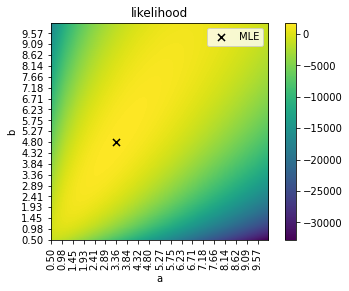

In [489]:
plt.imshow(r, origin="lower")
plt.colorbar();
plt.xticks(range(len(ar))[::10], [f"{i:.2f}" for i in ar[::10]], rotation="vertical");
plt.yticks(range(len(br))[::10], [f"{i:.2f}" for i in br[::10]]);
plt.xlabel("a")
plt.ylabel("b")
plt.title("likelihood")
plt.scatter(bi, ai, marker="x", color="black", s=50, label="MLE")
plt.legend();

observe how this makes intuitive sense, **fitting** reasonably well the distribution.

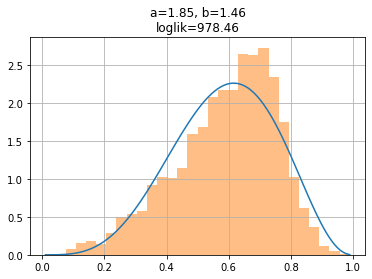

In [490]:
beta = stats.beta(a=ar[ai], b=br[bi])
plt.plot(xr, beta.pdf(xr))
plt.title(f"a={a:.2f}, b={b:.2f}\nloglik={loglik(a,b):.2f}")
plt.hist(x, bins=30, alpha=.5, density=True)
plt.grid();


Of course **MLE**, as any optimization, becomes **much harder** when we have a multivariate setting